# Reinforced learning, työllistyminen ja Suomen sosiaaliturva

Tässä tehdään laskelmat artikkelia varten. Käytössä on gym-ympäristö _unemployment-v1_ , johon on toteutettu yksityiskohtaisempi työttömyysturvamalli.

In [1]:
# for Colab, install fin_benefits and unemployment-gym from Github
#!pip install -q git+https://github.com/ajtanskanen/benefits.git  
#!pip install -q git+https://github.com/ajtanskanen/econogym.git
#!pip install -q git+https://github.com/ajtanskanen/lifecycle-rl.git

# and then restart kernel
  
  # For a specific version:
#!pip install tensorflow==1.15
#!pip install stable-baselines==2.8
  
# restart kernel after running pip's

Then load all modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lifecycle_rl import Lifecycle

%matplotlib inline
%pylab inline

# varoitukset piiloon (Stable baseline ei ole vielä Tensorflow 2.0-yhteensopiva, ja Tensorflow 1.5 valittaa paljon)
import warnings
warnings.filterwarnings('ignore')

pop_size=10_000
size1=20_000_000
size2=50_000_000
batch1=1
batch2=1000
deterministic=False # use deterministic prediction (True) or probabilitic prediction (False)
mortality=False # include mortality in computations
randomness=True # include randomness in the state transitions (e.g., maternity leave)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


# Nykymalli 

Lasketaan työllisyysasteet nykymallissa.

No mortality included
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 65
max_retirementage 70
ansiopvraha_kesto300 None
ansiopvraha_kesto400 None
ansiopvraha_toe None
perustulo False
karenssi_kesto 0.25
mortality False
randomness True
deterministic False

include_putki None
step 0.25

train...
phase 1
training...
---------------------------------
| explained_variance | 0.00272  |
| fps                | 1774     |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| policy_loss        | 52.4     |
| total_timesteps    | 0        |
| value_loss         | 1.53e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.624    |
| fps                | 2305     |
| nupdates           | 1000     |
| policy_entropy     | 0.969    |
| policy_loss        | -0.105   |
| total_timesteps    | 2458539  |
| value_loss         | 24.6     |
---------------------

2479536 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.11
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 218.43027 |
| explained_variance | 0.674     |
| fps                | 3199      |
| nupdates           | 12        |
| policy_entropy     | 0.564     |
| policy_loss        | -2.16     |
| total_timesteps    | 2273051   |
| value_loss         | 35.8      |
----------------------------------
2684556 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 217.40
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 216.02798 |
| explained_variance | 0.676     |
| fps                | 3199      |
| nupdates           | 13        |
| policy_entropy     | 0.568     |
| policy_loss        | -2.24     |
| total_timesteps    | 2479692   |
| value_loss         | 37.6      |
----------------------------------
2891988 timesteps
Best mean reward: 221.93 - Last mean reward per 

6198840 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.54
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 219.35402 |
| explained_variance | 0.82      |
| fps                | 3183      |
| nupdates           | 30        |
| policy_entropy     | 0.58      |
| policy_loss        | -0.191    |
| total_timesteps    | 5992589   |
| value_loss         | 14        |
----------------------------------
6403860 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.81
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 216.49677 |
| explained_variance | 0.844     |
| fps                | 3183      |
| nupdates           | 31        |
| policy_entropy     | 0.582     |
| policy_loss        | 0.0206    |
| total_timesteps    | 6199230   |
| value_loss         | 12.6      |
----------------------------------
6611292 timesteps
Best mean reward: 221.93 - Last mean reward per 

9918144 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 219.25
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 215.89636 |
| explained_variance | 0.839     |
| fps                | 3189      |
| nupdates           | 48        |
| policy_entropy     | 0.575     |
| policy_loss        | 0.00503   |
| total_timesteps    | 9712127   |
| value_loss         | 12.3      |
----------------------------------
10123164 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 219.01
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 219.70355 |
| explained_variance | 0.825     |
| fps                | 3189      |
| nupdates           | 49        |
| policy_entropy     | 0.57      |
| policy_loss        | -0.147    |
| total_timesteps    | 9918768   |
| value_loss         | 13.5      |
----------------------------------
10330596 timesteps
Best mean reward: 221.93 - Last mean reward pe

13637448 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.21
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 223.66962 |
| explained_variance | 0.838     |
| fps                | 3192      |
| nupdates           | 66        |
| policy_entropy     | 0.568     |
| policy_loss        | 0.2       |
| total_timesteps    | 13431665  |
| value_loss         | 12.3      |
----------------------------------
13844880 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.33
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 221.83296 |
| explained_variance | 0.856     |
| fps                | 3192      |
| nupdates           | 67        |
| policy_entropy     | 0.574     |
| policy_loss        | 0.303     |
| total_timesteps    | 13638306  |
| value_loss         | 11.2      |
----------------------------------
14049900 timesteps
Best mean reward: 221.93 - Last mean reward p

17356752 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.87
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 218.33588 |
| explained_variance | 0.85      |
| fps                | 3193      |
| nupdates           | 84        |
| policy_entropy     | 0.582     |
| policy_loss        | -0.326    |
| total_timesteps    | 17151203  |
| value_loss         | 12.3      |
----------------------------------
17564184 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.95
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 218.86769 |
| explained_variance | 0.85      |
| fps                | 3193      |
| nupdates           | 85        |
| policy_entropy     | 0.58      |
| policy_loss        | -0.289    |
| total_timesteps    | 17357844  |
| value_loss         | 11.9      |
----------------------------------
17769204 timesteps
Best mean reward: 221.93 - Last mean reward p

21076056 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 219.57
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 224.86424 |
| explained_variance | 0.872     |
| fps                | 3194      |
| nupdates           | 102       |
| policy_entropy     | 0.567     |
| policy_loss        | 0.0534    |
| total_timesteps    | 20870741  |
| value_loss         | 10        |
----------------------------------
21283488 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.27
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 221.77673 |
| explained_variance | 0.855     |
| fps                | 3194      |
| nupdates           | 103       |
| policy_entropy     | 0.559     |
| policy_loss        | -0.0537   |
| total_timesteps    | 21077382  |
| value_loss         | 11.1      |
----------------------------------
21488508 timesteps
Best mean reward: 221.93 - Last mean reward p

24795360 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 219.90
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 218.96861 |
| explained_variance | 0.854     |
| fps                | 3195      |
| nupdates           | 120       |
| policy_entropy     | 0.541     |
| policy_loss        | 0.164     |
| total_timesteps    | 24590279  |
| value_loss         | 11.4      |
----------------------------------
25002792 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 218.24
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 218.21857 |
| explained_variance | 0.863     |
| fps                | 3195      |
| nupdates           | 121       |
| policy_entropy     | 0.551     |
| policy_loss        | 0.144     |
| total_timesteps    | 24796920  |
| value_loss         | 11.4      |
----------------------------------
25207812 timesteps
Best mean reward: 221.93 - Last mean reward p

28514664 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.82
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 220.66461 |
| explained_variance | 0.85      |
| fps                | 3195      |
| nupdates           | 138       |
| policy_entropy     | 0.517     |
| policy_loss        | -0.0529   |
| total_timesteps    | 28309817  |
| value_loss         | 11.3      |
----------------------------------
28722096 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.54
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 217.74841 |
| explained_variance | 0.86      |
| fps                | 3195      |
| nupdates           | 139       |
| policy_entropy     | 0.517     |
| policy_loss        | -0.0296   |
| total_timesteps    | 28516458  |
| value_loss         | 11.2      |
----------------------------------
28929528 timesteps
Best mean reward: 221.93 - Last mean reward p

32233968 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.23
---------------------------------
| ep_len_mean        | 201      |
| ep_reward_mean     | 219.9899 |
| explained_variance | 0.859    |
| fps                | 3196     |
| nupdates           | 156      |
| policy_entropy     | 0.491    |
| policy_loss        | -0.112   |
| total_timesteps    | 32029355 |
| value_loss         | 11.2     |
---------------------------------
32441400 timesteps
Best mean reward: 221.93 - Last mean reward per episode: 220.41
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 214.99214 |
| explained_variance | 0.828     |
| fps                | 3196      |
| nupdates           | 157       |
| policy_entropy     | 0.488     |
| policy_loss        | -0.116    |
| total_timesteps    | 32235996  |
| value_loss         | 13.2      |
----------------------------------
32648832 timesteps
Best mean reward: 221.93 - Last mean reward per episode:

35953272 timesteps
New best mean reward: 222.05 - Last best reward per episode: 221.93
saved as  saved/best_perus
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 219.58725 |
| explained_variance | 0.858     |
| fps                | 3196      |
| nupdates           | 174       |
| policy_entropy     | 0.482     |
| policy_loss        | 0.0151    |
| total_timesteps    | 35748893  |
| value_loss         | 10.5      |
----------------------------------
36160704 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 219.08
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 217.64244 |
| explained_variance | 0.855     |
| fps                | 3197      |
| nupdates           | 175       |
| policy_entropy     | 0.502     |
| policy_loss        | -0.0474   |
| total_timesteps    | 35955534  |
| value_loss         | 11.6      |
----------------------------------
36368136 timesteps
Best mean rewa

39672576 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 220.95
---------------------------------
| ep_len_mean        | 201      |
| ep_reward_mean     | 220.1174 |
| explained_variance | 0.849    |
| fps                | 3197     |
| nupdates           | 192      |
| policy_entropy     | 0.49     |
| policy_loss        | -0.0161  |
| total_timesteps    | 39468431 |
| value_loss         | 11.7     |
---------------------------------
39880008 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 220.74
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 224.49164 |
| explained_variance | 0.854     |
| fps                | 3197      |
| nupdates           | 193       |
| policy_entropy     | 0.491     |
| policy_loss        | -0.0272   |
| total_timesteps    | 39675072  |
| value_loss         | 11.8      |
----------------------------------
40087440 timesteps
Best mean reward: 222.05 - Last mean reward per episode:

43394292 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 218.53
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 217.93312 |
| explained_variance | 0.854     |
| fps                | 3197      |
| nupdates           | 210       |
| policy_entropy     | 0.491     |
| policy_loss        | -0.0776   |
| total_timesteps    | 43187969  |
| value_loss         | 12.5      |
----------------------------------
43599312 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 220.83
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 222.87772 |
| explained_variance | 0.851     |
| fps                | 3197      |
| nupdates           | 211       |
| policy_entropy     | 0.475     |
| policy_loss        | -0.0335   |
| total_timesteps    | 43394610  |
| value_loss         | 11.9      |
----------------------------------
43806744 timesteps
Best mean reward: 222.05 - Last mean reward p

47113596 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 219.47
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 221.71758 |
| explained_variance | 0.863     |
| fps                | 3197      |
| nupdates           | 228       |
| policy_entropy     | 0.492     |
| policy_loss        | -0.0123   |
| total_timesteps    | 46907507  |
| value_loss         | 11.3      |
----------------------------------
47318616 timesteps
Best mean reward: 222.05 - Last mean reward per episode: 219.20
----------------------------------
| ep_len_mean        | 201       |
| ep_reward_mean     | 217.08998 |
| explained_variance | 0.865     |
| fps                | 3197      |
| nupdates           | 229       |
| policy_entropy     | 0.492     |
| policy_loss        | -0.0323   |
| total_timesteps    | 47114148  |
| value_loss         | 11.5      |
----------------------------------
47526048 timesteps
Best mean reward: 222.05 - Last mean reward p

0.6535142809866791


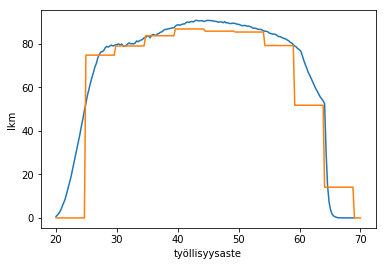

best_emp 0
Vaikutus työllisyyteen keskiarvo 2178314.0 htv, mediaani 2178314.0 htv
                        keskiarvo 2298628.0 työllistä, mediaani 2298628.0 työllistä


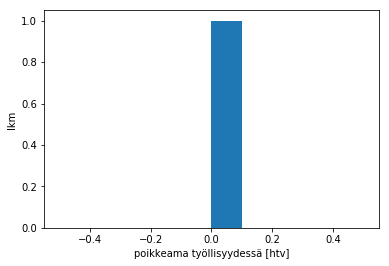

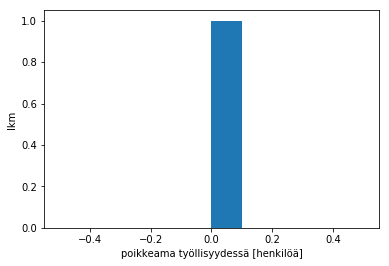

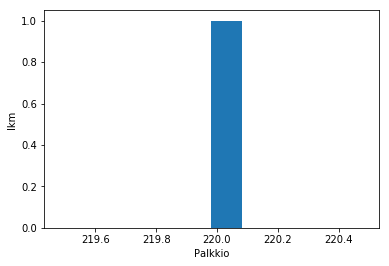

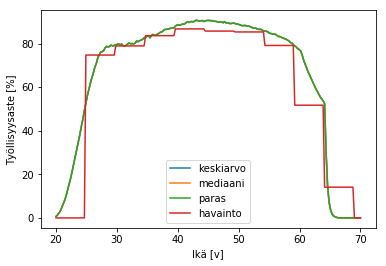

In [4]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              deterministic=deterministic,randomness=randomness)

cc1.explain()
cc1.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,bestname='saved/best_perus',
                plot=True,save='saved/perusmalli',cont=False,start_from='saved/best_perus')

# EK:n malli

Lasketaan vertailukelpoiset työllisyysasteet EK:n ehdottamalla mallilla. Mallissa on toteuttu muutoksia ansiosidonnaiseen työttömyysturvaan, asumistukeen, toimeentulotukeen ja verotukseen.

In [ ]:
cc2=Lifecycle(env='unemploymentEK-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness)
cc2.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,bestname='saved/best_ek',plot=True,
                save='saved/best_ek')

No mortality included
train...
phase 1
training...
---------------------------------
| explained_variance | 0.000587 |
| fps                | 1807     |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| policy_loss        | 53.1     |
| total_timesteps    | 0        |
| value_loss         | 1.58e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 2299     |
| nupdates           | 1000     |
| policy_entropy     | 0.95     |
| policy_loss        | 0.313    |
| total_timesteps    | 2458539  |
| value_loss         | 3.92     |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 2311     |
| nupdates           | 2000     |
| policy_entropy     | 0.688    |
| policy_loss        | 0.0515   |
| total_timesteps    | 4919539  |
| value_loss         | 1.67     |
---------------------------------
-------------------------------

In [ ]:
#cc1.simulate(pop=10_000,deterministic=True,load='best/best_perus',rlmodel='acktr',save='perusmalli',modify_load=False)
#cc2.simulate(pop=10_000,deterministic=True,load='best/best_ek',rlmodel='acktr',save='eknmalli',modify_load=False)
cc2.compare_with(cc1)

# Verifiointi

Ajetaan sama simulaatio kaksi kertaa ja tarkastetaan että tulokset ovat sama. Tässä ideana on varmistaa, että satunnaisuus ei sotke tulosten arviointia.

# Työssäoloehdon pituus 12 kk

Entä jos työssäoloehto olisikin 12 kuukautta pitkä nykyisen 6 kuukauden sijaan?

In [ ]:
cc1_toe=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_toe=1.0,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_toe.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_12kk',plot=True,
                    save='saved/malli_12')

In [ ]:
cc1_toe.compare_with(cc1)

# Ansiosidonnaisen päivärahan lyhennys 50 pv

Tarkastellaan, miten työllisyyteen vaikuttaisi ansiosidonnaisen päivärahan lyhentäminen 50 päivällä. Tällöin alle kolmen vuoden työhistorialla ansiosidonnaisen päivärahan enimmäiskesto olisi 250 pv ja pidemmällä työhistorialla enimmäiskesto olisi 350 pv.

In [ ]:
cc1_350=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=250,ansiopvraha_kesto400=350,
                  mortality=mortality,perustulo=False,randomness=randomness)
cc1_350.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_50pv',plot=True,
                    save='saved/malli_ek')

In [ ]:
cc1_350.compare_with(cc1)

# Työttömyysputken poisto

Työttömyysputki on suosittu elinkaarimalleissa. Tarkastellaan millainen työllisyysvaikutus on putken poistamisella.

In [ ]:
cc1_putki=Lifecycle(env='unemployment-v1',minimal=False,include_putki=False,mortality=mortality,
                    perustulo=False,randomness=randomness)
cc1_putki.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                      train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_putki',
                      plot=True,save='saved/malli_putki')
cc1_putki.compare_with(cc1)                    

# Perustulo

In [ ]:
cc1_pt=Lifecycle(env='unemployment-v1',minimal=False,perustulo=True,mortality=mortality,
                 randomness=randomness)
cc1_pt.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                   train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_pt',plot=True,
                   save='saved/malli_pt')

In [ ]:
cc1_pt.compare_with(cc1)

# 300 vs 400 päivän kesto ansiosidonnaisessa

Mikä on alle kolmen vuoden työhistorian lyhyemmän (300 pv) ansiosidonnaisen päivärahan enimmäiskeston vaikutus työllisyyteen? Kokeillaan miten työllisyyteen vaikuttaisi sen pidentäminen 400 päivään.

In [ ]:
cc1_400=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=400,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_400.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,bestname='best_300pv',plot=True,
                    save='saved/malli_300')
cc1_400.compare_with(cc1)